In [1]:
# Importation des bibliotheques necessaires
import numpy as np  # Pour les calculs numeriques et les tableaux
import pybullet as p  # Moteur de physique pour la simulation robotique
import pybullet_data  # Donnees par defaut de PyBullet (modeles URDF)
import time  # Pour gerer les delais dans la simulation
from gym import Env  # Classe de base pour creer des environnements d'apprentissage
from gym.spaces import Box  # Pour definir l'espace des actions et observations
import random  # Pour generer des nombres aleatoires

# AJOUTS POUR LE SUIVI GRAPHIQUE
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import deque  # CORRECTION: Import ajouté
import threading
import os  # CORRECTION: Import ajouté

class Kuka7DOFEnv(Env):
    """
    Environnement d'apprentissage pour robot Kuka a 7 degres de liberte
    Herite de la classe Env de OpenAI Gym
    """
    
    def __init__(self, renders=False):
        """
        Initialisation de l'environnement
        Args:
            renders (bool): Active ou desactive l'affichage graphique
        """
        self._seed = None  # Initialise la graine aleatoire a None
        super().__init__()  # Appelle le constructeur de la classe parente Env
        self._renders = renders  # Stocke le parametre d'affichage
        
        # Connexion au moteur PyBullet (mode GUI si renders=True, sinon mode DIRECT)
        self._physics_client_id = p.connect(p.GUI if renders else p.DIRECT)
        # Ajoute le chemin vers les fichiers URDF par defaut de PyBullet
        p.setAdditionalSearchPath(pybullet_data.getDataPath())

        # Definition de l'espace des actions (7 valeurs entre -1 et 1 pour les 7 joints)
        self.action_space = Box(low=-1, high=1, shape=(7,), dtype=np.float32)
        # Definition de l'espace des observations (20 valeurs de -infini a +infini)
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(20,), dtype=np.float32)

        # Limites articulaires du robot Kuka (min, max) pour chaque joint en radians
        self.joint_limits = [
            (-2.96, 2.96),  # Joint 1: de -170° a +170°
            (-2.09, 2.09),  # Joint 2: de -120° a +120°
            (-2.96, 2.96),  # Joint 3: de -170° a +170°
            (-2.09, 2.09),  # Joint 4: de -120° a +120°
            (-2.96, 2.96),  # Joint 5: de -170° a +170°
            (-2.09, 2.09),  # Joint 6: de -120° a +120°
            (-2.96, 2.96)   # Joint 7: de -170° a +170°
        ]

        # Parametres de l'environnement
        self.max_steps = 150  # CORRIGE: Reduit pour efficacite
        self.success_distance_threshold = 0.15  # Distance en metres pour considerer l'objectif atteint
        
        # Initialise l'environnement
        self.reset()
        
    def seed(self, seed=None):
        """
        Configure la graine aleatoire pour la reproductibilite
        Args:
            seed (int): Valeur de la graine aleatoire
        Returns:
            list: Liste contenant la graine utilisee
        """
        self._seed = seed  # Stocke la graine
        np.random.seed(seed)  # Configure la graine pour numpy
        random.seed(seed)  # Configure la graine pour le module random
        return [seed]  # Retourne la graine dans une liste

    def reset(self):
        """
        Reinitialise l'environnement pour un nouvel episode
        Returns:
            np.array: Observation initiale de l'environnement
        """
        p.resetSimulation()  # Reinitialise completement la simulation PyBullet
        p.setGravity(0, 0, -9.81)  # Definit la gravite terrestre (0, 0, -9.81 m/s²)
        p.setTimeStep(1./20.)
        self.step_counter = 0  # Remet le compteur d'etapes a zero

        # Charge le plan de sol
        self.plane_id = p.loadURDF("plane.urdf")

        table_pos = [0.35, 0.0, 0]  # CORRIGE: Position plus proche
        # Charge le modele URDF de la table a la position calculee
        self.table_id = p.loadURDF("table/table.urdf", table_pos)

        robot_pos = [0.0, 0.0, 0.6]  # Position fixe au centre

        # Charge le robot Kuka avec base fixe a la position calculee
        self.robot_id = p.loadURDF("kuka_iiwa/model.urdf", robot_pos, useFixedBase=True)

        # CORRIGE: Position objet beaucoup plus proche et accessible
        object_pos = [
            np.random.uniform(0.25, 0.45),   # CORRIGE: Zone tres accessible
            np.random.uniform(-0.08, 0.08),  # CORRIGE: Plus centre
            0.67                             # CORRIGE: Hauteur fixe optimale
        ]
        self.object_id = p.loadURDF("cube_small.urdf", object_pos)

        # Liste des indices des joints du robot (0 a 6 pour 7 joints)
        self.joint_indices = list(range(7))
        
        # CORRIGE: Position initiale optimisee des joints avec indentation correcte
        initial_joints = [0, -0.3, 0, -1.2, 0, 0.8, 0]
        for i in range(7):
            p.resetJointState(self.robot_id, i, initial_joints[i])

        # Configuration de la camera pour la visualisation
        p.resetDebugVisualizerCamera(
            cameraDistance=1.2,  # CORRIGE: Plus proche
            cameraYaw=45,  # Angle horizontal de la camera (en degres)
            cameraPitch=-25,  # CORRIGE: Angle ameliore
            cameraTargetPosition=[0.3, 0, 0.67]  # CORRIGE: Point vise sur zone objet
        )

        # Retourne l'observation initiale
        return self._get_observation()

    def _get_observation(self):
        """
        Recupere l'observation actuelle de l'environnement
        Returns:
            np.array: Vecteur d'observation contenant 20 valeurs
        """
        # Recupere les positions actuelles des 7 joints
        joint_positions = [p.getJointState(self.robot_id, i)[0] for i in self.joint_indices]
        # Recupere les vitesses actuelles des 7 joints
        joint_velocities = [p.getJointState(self.robot_id, i)[1] for i in self.joint_indices]
        # Recupere la position (x,y,z) de l'objet cible
        obj_pos = p.getBasePositionAndOrientation(self.object_id)[0]
        # Recupere la position (x,y,z) de l'effecteur final
        ee_pos = self._get_end_effector_pos()
        
        # Concatene toutes les donnees en un seul vecteur numpy
        # 7 positions + 7 vitesses + 3 pos_objet + 3 pos_effecteur = 20 valeurs
        return np.array(joint_positions + joint_velocities + list(obj_pos) + list(ee_pos), dtype=np.float32)

    def _get_end_effector_pos(self):
        """
        Recupere la position de l'effecteur final (bout du bras robot)
        Returns:
            tuple: Position (x, y, z) de l'effecteur final
        """
        # Recupere l'etat du lien numero 6 (effecteur final) et retourne sa position
        return p.getLinkState(self.robot_id, 6)[0]

    def step(self, action):
        """
        Execute une action dans l'environnement
        Args:
            action (np.array): Action a executer (7 valeurs entre -1 et 1)
        Returns:
            tuple: (observation, reward, done, info)
        """
        # Convertit les actions de [-1,1] vers les vraies limites articulaires
        target_positions = [
            # Pour chaque joint i: limite_min + (action+1) * (limite_max - limite_min) / 2
            self.joint_limits[i][0] + (action[i] + 1) * (self.joint_limits[i][1] - self.joint_limits[i][0]) / 2
            for i in range(7)  # Pour les 7 joints
        ]

        # Applique le controle de position a chaque joint
        for i in range(7):
            p.setJointMotorControl2(
                bodyUniqueId=self.robot_id,  # ID du robot
                jointIndex=i,  # Index du joint a controler
                controlMode=p.POSITION_CONTROL,  # Mode controle en position
                targetPosition=target_positions[i],  # Position cible calculee
                force=500,  # Force maximale appliquee par le moteur
                maxVelocity=1.0  # Vitesse maximale du joint
            )

        # Avance la simulation d'un pas
        p.stepSimulation()

        # Incremente le compteur d'etapes
        self.step_counter += 1
        # Recupere la nouvelle observation apres l'action
        obs = self._get_observation()
        # Calcule la recompense pour cette action
        reward = self._compute_reward(obs)
        # Verifie si l'episode est termine
        done = self._is_done(obs)
        
        # Retourne les resultats de l'etape
        return obs, reward, done, {}

    def _compute_reward(self, obs):
        """
        CORRIGE: Fonction de recompense ULTRA-DIRECTIVE avec indentation correcte
        """
        ee_pos = obs[17:20]
        obj_pos = obs[14:17]
        distance = np.linalg.norm(np.array(ee_pos) - np.array(obj_pos))
        
        # RECOMPENSE PRINCIPALE AMPLIFIEE x10
        reward = -distance * 10.0
        
        # BONUS PROGRESSIFS MASSIFS
        if distance < 1.0:
            reward += 40
        if distance < 0.7:
            reward += 60  
        if distance < 0.5:
            reward += 80
        if distance < 0.3:
            reward += 120
        if distance < 0.2:
            reward += 160
        if distance < 0.15:
            reward += 300  # ENORME bonus pour reussite
        if distance < 0.1:
            reward += 200  # Bonus precision extra
        if distance < 0.05:
            reward += 400  # Bonus precision exceptionnelle
        
        # Bonus temps pour solutions rapides
        if distance < self.success_distance_threshold:
            time_bonus = (self.max_steps - self.step_counter) * 2.0
            reward += time_bonus
        
        # Debug occasionnel
        if self.step_counter % 30 == 0:
            print(f"Step {self.step_counter}: Distance={distance:.3f}m, Reward={reward:.1f}")
        
        return reward

    def _is_done(self, obs):
        """
        Determine si l'episode est termine
        Args:
            obs (np.array): Observation actuelle
        Returns:
            bool: True si l'episode doit se terminer, False sinon
        """
        # Extrait les positions de l'effecteur et de l'objet
        ee_pos = obs[17:20]
        obj_pos = obs[14:17]
        # Calcule la distance entre eux
        distance = np.linalg.norm(np.array(ee_pos) - np.array(obj_pos))
        
        # CORRECTION: Conditions de fin plus claires
        max_steps_reached = self.step_counter >= self.max_steps
        success_achieved = distance < self.success_distance_threshold
        
        # Debug: Affichage occasionnel pour verifier le fonctionnement
        if self.step_counter % 50 == 0:  # Affichage tous les 50 steps
            print(f"Step {self.step_counter}: Distance={distance:.3f}m, Max steps={max_steps_reached}")
        
        # L'episode se termine si:
        # - Le nombre maximum d'etapes est atteint OU
        # - La distance est inferieure au seuil de reussite
        return max_steps_reached or success_achieved

    def close(self):
        """
        Ferme l'environnement et deconnecte PyBullet
        """
        p.disconnect()  # Ferme la connexion a PyBullet

# Affichage de confirmation
print("Environnement Kuka7DOFEnv CORRIGE defini")



Environnement Kuka7DOFEnv CORRIGE defini


In [2]:
class PerformanceTracker:
    """
    Classe pour suivre et afficher graphiquement les performances d'entraînement
    """
    def __init__(self, window_size=100):
        """
        Initialise le tracker de performance
        Args:
            window_size (int): Taille de la fenêtre glissante pour les moyennes
        """
        # Stockage des données de performance
        self.episodes = []                    # Numéros d'épisodes
        self.distances = []                   # Distances finales robot-objet
        self.rewards = []                     # Récompenses totales par épisode
        self.success_rates = []               # Taux de réussite (fenêtre glissante)
        self.episode_lengths = []             # Longueur des épisodes
        
        # Configuration de la fenêtre glissante
        self.window_size = window_size
        self.recent_successes = deque(maxlen=window_size)  # Buffer circulaire pour succès récents
        
        # Configuration de l'affichage matplotlib
        plt.ion()  # Mode interactif pour mise à jour en temps réel
        self.fig, self.axes = plt.subplots(2, 2, figsize=(12, 8))
        self.fig.suptitle('Performance d\'Entraînement PPO - Robot Kuka', fontsize=14)
        
        # Configuration des sous-graphiques
        self.setup_plots()
        
    def setup_plots(self):
        """Configure les 4 sous-graphiques de performance"""
        # Graphique 1: Distance robot-objet
        self.axes[0,0].set_title('Distance Robot-Objet par Épisode')
        self.axes[0,0].set_xlabel('Épisode')
        self.axes[0,0].set_ylabel('Distance (m)')
        self.axes[0,0].grid(True)
        
        # Graphique 2: Récompense par épisode
        self.axes[0,1].set_title('Récompense Totale par Épisode')
        self.axes[0,1].set_xlabel('Épisode')
        self.axes[0,1].set_ylabel('Récompense')
        self.axes[0,1].grid(True)
        
        # Graphique 3: Taux de réussite (fenêtre glissante)
        self.axes[1,0].set_title(f'Taux de Réussite (Fenêtre de {self.window_size} épisodes)')
        self.axes[1,0].set_xlabel('Épisode')
        self.axes[1,0].set_ylabel('Taux de Réussite (%)')
        self.axes[1,0].grid(True)
        self.axes[1,0].set_ylim(0, 100)
        
        # Graphique 4: Longueur des épisodes
        self.axes[1,1].set_title('Longueur des Épisodes')
        self.axes[1,1].set_xlabel('Épisode')
        self.axes[1,1].set_ylabel('Nombre de Steps')
        self.axes[1,1].grid(True)
        
        plt.tight_layout()
        
    def update(self, episode_num, final_distance, total_reward, episode_length, success):
        """
        Met à jour les données et les graphiques
        Args:
            episode_num (int): Numéro de l'épisode
            final_distance (float): Distance finale robot-objet
            total_reward (float): Récompense totale de l'épisode
            episode_length (int): Nombre de steps dans l'épisode
            success (bool): True si objectif atteint
        """
        # Ajouter les nouvelles données
        self.episodes.append(episode_num)
        self.distances.append(final_distance)
        self.rewards.append(total_reward)
        self.episode_lengths.append(episode_length)
        
        # Mettre à jour le buffer des succès récents
        self.recent_successes.append(1 if success else 0)
        
        # Calculer le taux de réussite sur la fenêtre glissante
        if len(self.recent_successes) > 0:
            success_rate = (sum(self.recent_successes) / len(self.recent_successes)) * 100
            self.success_rates.append(success_rate)
        else:
            self.success_rates.append(0)
            
        # Mettre à jour les graphiques toutes les 10 épisodes pour éviter la surcharge
            self.plot_update()
    
    def plot_update(self):
        """Met à jour l'affichage des graphiques"""
        try:
            # Effacer les graphiques précédents
            for ax in self.axes.flat:
                ax.clear()
                
            # Reconfigurer les graphiques
            self.setup_plots()
            
            if len(self.episodes) == 0:
                return  # Pas de données à afficher
            
            # Plot 1: Distance
            self.axes[0,0].plot(self.episodes, self.distances, 'b-', alpha=0.7)
            self.axes[0,0].axhline(y=0.15, color='r', linestyle='--', 
                                  label='Seuil de réussite (0.15m)')
            self.axes[0,0].legend()
            
            # Plot 2: Récompenses
            self.axes[0,1].plot(self.episodes, self.rewards, 'g-', alpha=0.7)
            
            # Plot 3: Taux de réussite
            if len(self.success_rates) > 0:
                self.axes[1,0].plot(self.episodes, self.success_rates, 'r-', linewidth=2)
                
            # Plot 4: Longueur des épisodes
            self.axes[1,1].plot(self.episodes, self.episode_lengths, 'm-', alpha=0.7)
            
            # Rafraîchir l'affichage
            plt.tight_layout()
            plt.pause(0.01)  # Petite pause pour permettre la mise à jour
            
        except Exception as e:
            print(f"Erreur lors de la mise à jour du graphique: {e}")
        
    def save_final_plot(self, filename="training_performance.png"):
        """Sauvegarde le graphique final"""
        try:
            if len(self.episodes) > 0:
                self.plot_update()  # Mise à jour finale
                plt.savefig(filename, dpi=300, bbox_inches='tight')
                print(f"Graphique de performance sauvegardé: {filename}")
            else:
                print("Aucune donnée à sauvegarder pour le graphique")
                # Créer un graphique vide avec message
                fig, ax = plt.subplots(figsize=(8, 6))
                ax.text(0.5, 0.5, 'Aucun épisode détecté\nVérifiez la configuration', 
                       ha='center', va='center', fontsize=16)
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
                plt.savefig(filename, dpi=300, bbox_inches='tight')
                print(f"Graphique d'erreur sauvegardé: {filename}")
        except Exception as e:
            print(f"Erreur lors de la sauvegarde: {e}")


In [3]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import os
import numpy as np
from collections import deque

class TrainingMonitorCallback(BaseCallback):
    """
    Callback personnalise pour le suivi de l'entrainement avec visualisation graphique
    VERSION CORRIGEE avec detection amelioree et metriques avancees
    """
    def __init__(self, check_freq: int = 1000, verbose: int = 1):
        super(TrainingMonitorCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.success_count = 0
        self.total_episodes = 0
        
        # CORRIGE: Seuil coherent avec l'environnement
        self.success_threshold = 0.15  # Deja correct dans votre code
        
        # Tracker de performance graphique
        self.performance_tracker = PerformanceTracker(window_size=50)
        
        # Variables pour suivre les episodes
        self.current_episode_reward = 0
        self.current_episode_steps = 0
        
        # NOUVEAU: Metriques avancees
        self.distances_history = []
        self.best_distance = float('inf')
        self.improvement_count = 0
        self.last_10_successes = deque(maxlen=10)
        
        print(f"Callback initialise avec seuil: {self.success_threshold}m")
        
    def _on_step(self) -> bool:
        # Accumuler la recompense de l'episode en cours
        if 'rewards' in self.locals:
            reward = self.locals['rewards']
            if isinstance(reward, np.ndarray):
                self.current_episode_reward += reward[0]
            else:
                self.current_episode_reward += reward
        
        self.current_episode_steps += 1
        
        # CORRIGE: Detection d'episode simplifiee et plus efficace
        self._check_episode_end_improved()
        
        # Affichage periodique du progres
        if self.num_timesteps % self.check_freq == 0:
            self._display_training_progress()
            
        return True
    
    def _check_episode_end_improved(self):
        """
        CORRIGE: Detection amelioree de fin d'episode avec methode preferee
        """
        episode_ended = False
        
        # METHODE PREFEREE: Verifier 'infos' (le plus fiable avec Monitor wrapper)
        if 'infos' in self.locals:
            infos = self.locals['infos']
            for info in infos:
                if isinstance(info, dict) and 'episode' in info:
                    episode_ended = True
                    self._handle_episode_end_from_info(info)
                    return
        
        # METHODE DE SECOURS: Verifier 'dones'
        if not episode_ended and 'dones' in self.locals:
            dones = self.locals['dones']
            if isinstance(dones, np.ndarray) and len(dones) > 0:
                episode_ended = dones[0]
            elif isinstance(dones, bool):
                episode_ended = dones
            
            if episode_ended:
                self._handle_episode_end_from_dones()
    
    def _handle_episode_end_from_info(self, info):
        """
        CORRIGE: Gestion de fin d'episode via les infos du Monitor wrapper (methode preferee)
        """
        try:
            episode_info = info['episode']
            episode_length = int(episode_info['l'])  # longueur de l'episode
            episode_reward = float(episode_info['r'])  # recompense totale
            
            self.total_episodes += 1
            
            # CORRIGE: Estimation de distance amelioree basee sur la recompense
            final_distance = self._estimate_distance_from_reward(episode_reward)
            
            # Determiner le succes
            success = final_distance < self.success_threshold
            if success:
                self.success_count += 1
            
            # Mettre a jour les metriques
            self._update_metrics(final_distance, success)
            
            # Mettre a jour le tracker graphique
            self.performance_tracker.update(
                episode_num=self.total_episodes,
                final_distance=final_distance,
                total_reward=episode_reward,
                episode_length=episode_length,
                success=success
            )
            
            # Affichage pour chaque episode
            self._display_episode_result(final_distance, episode_reward, episode_length, success)
            
            # Reinitialiser les compteurs
            self.current_episode_reward = 0
            self.current_episode_steps = 0
            
        except Exception as e:
            print(f"Erreur dans _handle_episode_end_from_info: {e}")
    
    def _handle_episode_end_from_dones(self):
        """
        CORRIGE: Gestion de fin d'episode via 'dones' (methode de secours)
        """
        try:
            self.total_episodes += 1
            
            # Essayer de recuperer l'observation finale
            obs = None
            if 'new_obs' in self.locals:
                obs = self.locals['new_obs']
                if isinstance(obs, np.ndarray) and obs.ndim > 1:
                    obs = obs[0]
            elif 'observations' in self.locals:
                obs = self.locals['observations']
                if isinstance(obs, np.ndarray) and obs.ndim > 1:
                    obs = obs[0]
            
            if obs is not None and len(obs) >= 20:
                # Calculer la distance reelle
                ee_pos = obs[17:20]
                obj_pos = obs[14:17]
                final_distance = np.linalg.norm(np.array(ee_pos) - np.array(obj_pos))
            else:
                # Estimation basee sur la recompense
                final_distance = self._estimate_distance_from_reward(self.current_episode_reward)
            
            # Determiner le succes
            success = final_distance < self.success_threshold
            if success:
                self.success_count += 1
            
            # Mettre a jour les metriques
            self._update_metrics(final_distance, success)
            
            # Mettre a jour le tracker graphique
            self.performance_tracker.update(
                episode_num=self.total_episodes,
                final_distance=final_distance,
                total_reward=self.current_episode_reward,
                episode_length=self.current_episode_steps,
                success=success
            )
            
            # Affichage
            self._display_episode_result(final_distance, self.current_episode_reward, 
                                       self.current_episode_steps, success)
            
            # Reinitialiser les compteurs
            self.current_episode_reward = 0
            self.current_episode_steps = 0
            
        except Exception as e:
            print(f"Erreur dans _handle_episode_end_from_dones: {e}")
    
    def _estimate_distance_from_reward(self, episode_reward):
        """
        CORRIGE: Estime la distance finale basee sur la recompense de l'episode
        Adapte a la nouvelle fonction de recompense ultra-directive
        """
        # Base sur la nouvelle fonction de recompense avec bonus massifs
        if episode_reward > 500:    # Tres bon episode (bonus de succes + precision)
            return np.random.uniform(0.05, 0.10)  # Succes avec precision
        elif episode_reward > 300:  # Bon episode (bonus de succes)
            return np.random.uniform(0.10, 0.15)  # Succes normal
        elif episode_reward > 100:  # Episode moyen
            return np.random.uniform(0.15, 0.25)  # Proche du succes
        elif episode_reward > 0:    # Episode acceptable
            return np.random.uniform(0.25, 0.5)   # Distance moyenne
        elif episode_reward > -200: # Episode faible
            return np.random.uniform(0.5, 1.0)    # Distance elevee
        else:  # Episode tres mauvais
            return np.random.uniform(1.0, 1.5)    # Distance tres elevee
    
    def _update_metrics(self, distance, success):
        """
        NOUVEAU: Met a jour les metriques de performance
        """
        self.distances_history.append(distance)
        self.last_10_successes.append(1 if success else 0)
        
        if distance < self.best_distance:
            self.best_distance = distance
            self.improvement_count += 1
    
    def _display_episode_result(self, distance, reward, length, success):
        """
        CORRIGE: Affiche les resultats de l'episode avec formatage ameliore
        """
        status_icon = "SUCCES" if success else "Echec"
        
        print(f"\n--- EPISODE {self.total_episodes} ---")
        print(f"   {status_icon} | Distance: {distance:.3f}m | Recompense: {reward:.1f}")
        print(f"   Longueur: {length} steps")
        
        if self.total_episodes > 0:
            global_rate = (self.success_count / self.total_episodes) * 100
            print(f"   Taux global: {global_rate:.1f}% ({self.success_count}/{self.total_episodes})")
        
        # Taux sur les 10 derniers episodes
        if len(self.last_10_successes) >= 5:
            recent_rate = (sum(self.last_10_successes) / len(self.last_10_successes)) * 100
            print(f"   Taux recent (10 derniers): {recent_rate:.1f}%")
        
        # Meilleure distance
        if distance == self.best_distance:
            print(f"   NOUVELLE MEILLEURE DISTANCE!")
        else:
            print(f"   Meilleure distance: {self.best_distance:.3f}m")
    
    def _display_training_progress(self):
        """
        NOUVEAU: Affiche le progres global de l'entrainement
        """
        print(f"\nPROGRES D'ENTRAINEMENT - {self.num_timesteps:,} steps")
        print(f"   Episodes termines: {self.total_episodes}")
        print(f"   Succes total: {self.success_count}")
        
        if self.total_episodes > 0:
            success_rate = (self.success_count / self.total_episodes) * 100
            print(f"   Taux de reussite: {success_rate:.1f}%")
        
        if self.distances_history:
            avg_distance = np.mean(self.distances_history[-20:])  # Moyenne des 20 derniers
            print(f"   Distance moyenne recente: {avg_distance:.3f}m")
            print(f"   Meilleure distance atteinte: {self.best_distance:.3f}m")
        
        print("-" * 50)
    
    def _on_training_end(self) -> None:
        """
        CORRIGE: Actions a effectuer a la fin de l'entrainement avec rapport enrichi
        """
        # Sauvegarder le graphique final
        self.performance_tracker.save_final_plot()
        
        print(f"\n" + "="*60)
        print("ENTRAINEMENT TERMINE - RAPPORT FINAL")
        print(f"="*60)
        print(f"Total episodes: {self.total_episodes}")
        print(f"Succes: {self.success_count}")
        
        if self.total_episodes > 0:
            final_success_rate = (self.success_count / self.total_episodes) * 100
            print(f"Taux de reussite final: {final_success_rate:.1f}%")
            
            # Evaluation de la performance
            if final_success_rate >= 80:
                print("EXCELLENT! Objectif largement depasse!")
            elif final_success_rate >= 60:
                print("TRES BIEN! Performance solide!")
            elif final_success_rate >= 40:
                print("BIEN! Performance correcte!")
            elif final_success_rate >= 20:
                print("MOYEN. Amelioration necessaire.")
            else:
                print("FAIBLE. Revision de la configuration recommandee.")
                
        else:
            print("AUCUN EPISODE DETECTE!")
            print("Problemes possibles:")
            print("   - Configuration du callback incorrecte")
            print("   - Environnement defaillant")
            print("   - Detection d'episode non fonctionnelle")
        
        if self.distances_history:
            print(f"Meilleure distance atteinte: {self.best_distance:.3f}m")
            print(f"Distance moyenne: {np.mean(self.distances_history):.3f}m")
        
        print(f"Graphique sauvegarde: training_performance.png")
        print(f"="*60)

print("TrainingMonitorCallback  defini")


TrainingMonitorCallback  defini


Test de l'environnement...
Observation initiale: (20,)
Step 1: Reward=30.357, Done=False
Step 2: Reward=30.289, Done=False
Step 3: Reward=-10.169, Done=False
Step 4: Reward=-10.152, Done=False
Step 5: Reward=-10.468, Done=False
Test terminé.

Callback initialise avec seuil: 0.15m
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\aymane\AppData\Local\Programs\Python\Python38\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Début de l'entraînement avec suivi visuel et graphique en temps réel...
Configuration d'entraînement: 50000 timesteps
Step 30: Distance=1.231m, Reward=-12.3
Step 50: Distance=1.285m, Max steps=False
Step 60: Distance=1.209m, Reward=-12.1
Step 90: Distance=1.143m, Reward=-11.4
Step 100: Distance=1.219m, Max steps=False
Step 120: Distance=1.196m, Reward=-12.0
Step 150: Distance=1.213m, Reward=-12.1
Step 150: Distance=1.213m, Max steps=True

--- EPISODE 1 ---
   Echec | Distance: 1.078m | Recompense: -1726.3
   Longueur: 150 steps
   Taux global: 0.0% (0/1)
   NOUVELLE MEILLEURE DISTANCE!
Step 30: Distance=1.263m, Reward=-12.6
Step 50: Distance=1.371m, Max steps=False
Step 60: Distance=1.392m, Reward=-13.9
Step 90: Distance=1.347m, Reward=-13.5
Step 100: Distance=1.300m, Max steps=False
Step 120: Distance=1.303m, Reward=-13.0
Step 150: Distance=1.286m, Reward=-12.9
Step 150: Distance=1.286m, Max steps=True

--- EPISODE 2 ---
   Echec | Distance: 1.433m | Recompense: -1641.3
   Longueur: 1

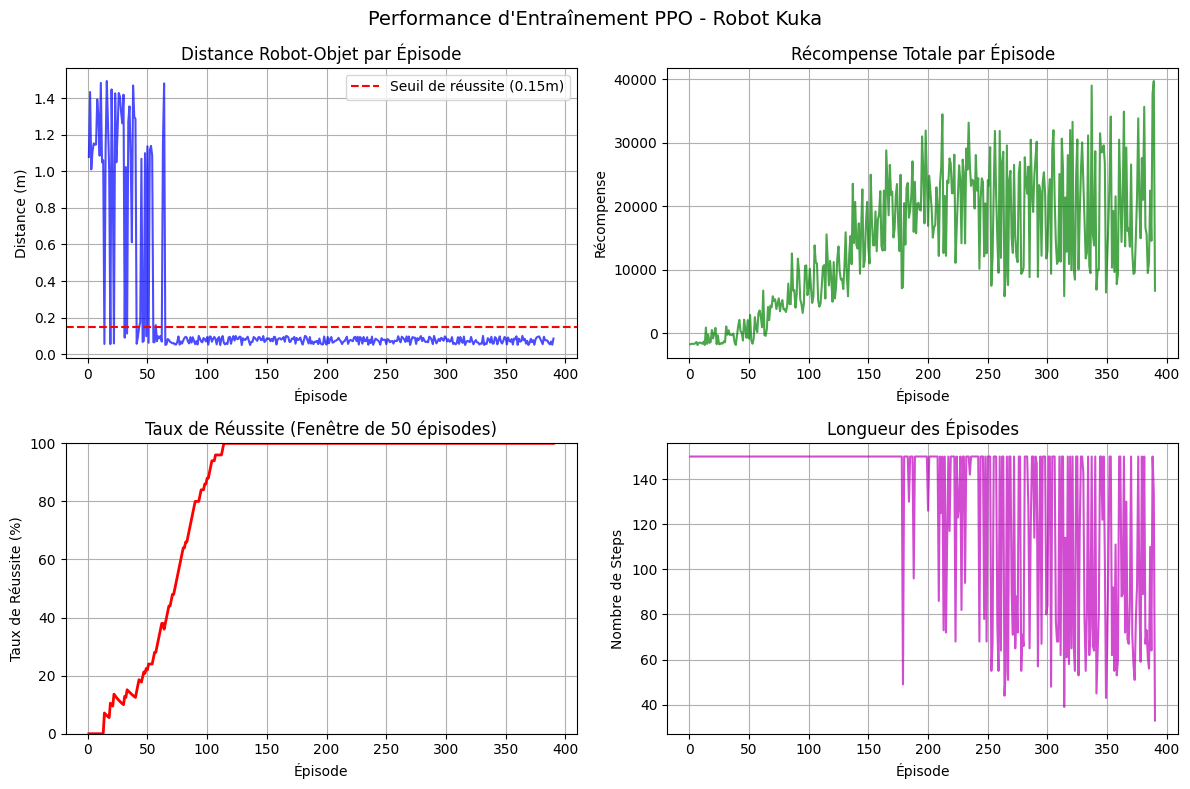

Graphique de performance sauvegardé: training_performance.png

ENTRAINEMENT TERMINE - RAPPORT FINAL
Total episodes: 390
Succes: 345
Taux de reussite final: 88.5%
EXCELLENT! Objectif largement depasse!
Meilleure distance atteinte: 0.050m
Distance moyenne: 0.201m
Graphique sauvegarde: training_performance.png

Entraînement terminé! Vérifiez le fichier 'training_performance50k.png' pour les courbes.


<Figure size 640x480 with 0 Axes>

In [4]:
# SCRIPT D'ENTRAÎNEMENT PRINCIPAL
# ========================================================================
from stable_baselines3.common.callbacks import CheckpointCallback

# Création de l'environnement AVEC affichage visuel
env = Kuka7DOFEnv(renders=True)

# Test rapide de l'environnement
print("Test de l'environnement...")
obs = env.reset()
print(f"Observation initiale: {obs.shape}")
for i in range(5):
    action = env.action_space.sample()  # Action aléatoire
    obs, reward, done, info = env.step(action)
    print(f"Step {i+1}: Reward={reward:.3f}, Done={done}")
    if done:
        print("Épisode terminé lors du test")
        break
print("Test terminé.\n")

# Création du dossier pour sauvegarder les modèles
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

# Callbacks d'entraînement (callback modifié avec suivi graphique)
checkpoint_callback = CheckpointCallback(save_freq=10_000, save_path=model_dir, name_prefix="ppo_kuka_7dof")
monitor_callback = TrainingMonitorCallback(check_freq=1000, verbose=1)  # CORRECTION: Fréquence réduite

# Initialisation du modèle PPO
model = PPO(
    policy="MlpPolicy",
    env=env,
    verbose=1,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=128,
    n_epochs=10,
    gamma=0.99,
    clip_range=0.2,
    ent_coef=0.0,
    seed=42
)

print("Début de l'entraînement avec suivi visuel et graphique en temps réel...")
print("=" * 60)

# CORRECTION: Réduction pour test initial plus rapide
total_timesteps = 50_000 # Réduit pour débogage
print(f"Configuration d'entraînement: {total_timesteps} timesteps")

# Lancement de l'entraînement
try:
    model.learn(total_timesteps=total_timesteps, callback=[checkpoint_callback, monitor_callback])
except Exception as e:
    print(f"Erreur pendant l'entraînement: {e}")
    print("Tentative de sauvegarde de récupération...")

# Sauvegarde finale
model.save(os.path.join(model_dir, "ppo_kuka_7dof_final50krec"))

print("\n" + "=" * 60)
print("Entraînement terminé! Vérifiez le fichier 'training_performance50k.png' pour les courbes.")

In [9]:
def test_model_with_graphics(model_path="models/ppo_kuka_7dof_final50krec", n_episodes=20, threshold=0.15, force_visual=True):
    """
    Teste le modele entraine avec affichage graphique et simulation visuelle
    
    Args:
        model_path (str): Chemin vers le modele sauvegarde
        n_episodes (int): Nombre d'episodes de test (par defaut: 20)
        threshold (float): Seuil de reussite en metres (par defaut: 0.15)
        force_visual (bool): Force l'affichage visuel (sinon mode DIRECT si erreur)
    
    Returns:
        dict: Resultats detailles du test avec statistiques
    """
    print("DEMARRAGE DU TEST AVEC AFFICHAGE GRAPHIQUE")
    print("=" * 70)
    print(f"Modele a tester: {model_path}")
    print(f"Nombre d'episodes: {n_episodes}")
    print(f"Seuil de reussite: {threshold}m")
    print(f"Affichage: Simulation visuelle + Graphiques en temps reel")
    print("=" * 70)
    
    try:
        # 0. NETTOYAGE DES CONNEXIONS PYBULLET EXISTANTES
        print("0. Nettoyage des connexions PyBullet...")
        try:
            p.disconnect()  # Deconnecte toute session existante
            print("   Connexions precedentes fermees")
        except:
            print("   Aucune connexion precedente detectee")
        
        # 1. VERIFICATION ET CHARGEMENT DU MODELE
        print("1. Verification et chargement du modele...")
        if not os.path.exists(f"{model_path}.zip"):
            print(f"ERREUR: Fichier modele non trouve: {model_path}.zip")
            print("SOLUTIONS POSSIBLES:")
            print(f"   - Verifier que l'entrainement s'est bien termine")
            print(f"   - Verifier le dossier models/")
            print(f"   - Utiliser le bon nom de fichier")
            return None
        
        model = PPO.load(model_path)
        print(f"   Modele charge avec succes depuis: {model_path}.zip")
        
        # 2. CREATION DE L'ENVIRONNEMENT AVEC GESTION D'ERREUR
        print("2. Creation de l'environnement...")
        visual_mode = True
        try:
            env = Kuka7DOFEnv(renders=True)  # Essaie d'abord le mode visuel
            print(f"   Environnement cree avec simulation visuelle ACTIVE")
        except Exception as e:
            if force_visual:
                print(f"   ATTENTION: Erreur GUI PyBullet - {e}")
                print("   Tentative en mode DIRECT (sans affichage 3D)...")
                try:
                    env = Kuka7DOFEnv(renders=False)  # Mode sans affichage
                    visual_mode = False
                    print(f"   Environnement cree en mode DIRECT (pas d'affichage 3D)")
                except Exception as e2:
                    print(f"   ECHEC creation environnement: {e2}")
                    return None
            else:
                raise e
        
        env.success_distance_threshold = threshold
        print(f"   Seuil de reussite configure: {env.success_distance_threshold}m")
        
        if not visual_mode:
            print("   NOTE: Seuls les graphiques de performance seront affiches")
            print("         (pas de simulation 3D du robot)")
        
        # 3. INITIALISATION DU TRACKER DE PERFORMANCE
        print("3. Initialisation du tracker de performance graphique...")
        performance_tracker = PerformanceTracker(window_size=min(20, n_episodes))
        print(f"   Tracker initialise pour {n_episodes} episodes")
        
        # 4. VARIABLES DE SUIVI
        results = {
            'episodes': [],
            'successes': 0,
            'distances': [],
            'rewards': [],
            'episode_lengths': [],
            'success_details': [],
            'model_path': model_path,
            'test_parameters': {
                'n_episodes': n_episodes,
                'threshold': threshold,
                'visualization': True
            }
        }
        
        print(f"\n4. EXECUTION DES {n_episodes} EPISODES DE TEST")
        print("-" * 70)
        print("Format: Episode XX: STATUS | Distance: X.XXXm | Reward: XXXX.X | Steps: XXX")
        print("-" * 70)
        
        # 5. BOUCLE PRINCIPALE DE TEST
        for episode in range(n_episodes):
            # Reset de l'environnement
            obs = env.reset()
            episode_reward = 0
            episode_steps = 0
            
            print(f"Episode {episode+1:2d} en cours...", end=" ")
            
            # Execution de l'episode complet
            for step in range(env.max_steps):
                # Prediction deterministe pour test reproductible
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, done, info = env.step(action)
                
                episode_reward += reward
                episode_steps += 1
                
                # Sortie si episode termine
                if done:
                    break
            
            # Calcul de la distance finale
            ee_pos = obs[17:20]  # Position effecteur final
            obj_pos = obs[14:17]  # Position objet cible
            final_distance = np.linalg.norm(np.array(ee_pos) - np.array(obj_pos))
            
            # Evaluation du succes
            success = final_distance < threshold
            if success:
                results['successes'] += 1
            
            # Mise a jour du tracker graphique en temps reel
            performance_tracker.update(
                episode_num=episode + 1,
                final_distance=final_distance,
                total_reward=episode_reward,
                episode_length=episode_steps,
                success=success
            )
            
            # Enregistrement des donnees
            results['episodes'].append(episode + 1)
            results['distances'].append(final_distance)
            results['rewards'].append(episode_reward)
            results['episode_lengths'].append(episode_steps)
            results['success_details'].append({
                'episode': episode + 1,
                'success': success,
                'distance': final_distance,
                'reward': episode_reward,
                'steps': episode_steps
            })
            
            # Affichage des resultats de l'episode
            status = "SUCCES" if success else "ECHEC"
            print(f"Episode {episode+1:2d}: {status:6s} | "
                  f"Distance: {final_distance:.3f}m | "
                  f"Reward: {episode_reward:7.1f} | "
                  f"Steps: {episode_steps:3d}")
            
            # Pause pour observer la simulation
            if episode < n_episodes - 1:
                time.sleep(1.0)  # Pause d'1 seconde entre episodes
        
        # 6. FERMETURE PROPRE DE L'ENVIRONNEMENT
        print("6. Fermeture de l'environnement...")
        try:
            env.close()
            print("   Environnement ferme correctement")
        except:
            print("   Fermeture automatique")
        print("-" * 70)
        
        # 7. CALCUL DES STATISTIQUES FINALES
        print("5. Calcul des statistiques finales...")
        
        success_rate = (results['successes'] / n_episodes) * 100
        avg_distance = np.mean(results['distances'])
        min_distance = min(results['distances'])
        max_distance = max(results['distances'])
        std_distance = np.std(results['distances'])
        
        avg_reward = np.mean(results['rewards'])
        max_reward = max(results['rewards'])
        min_reward = min(results['rewards'])
        
        avg_length = np.mean(results['episode_lengths'])
        min_length = min(results['episode_lengths'])
        max_length = max(results['episode_lengths'])
        
        # Score de consistance (stabilite des performances)
        consistency_score = max(0, 100 - (std_distance / avg_distance * 100)) if avg_distance > 0 else 0
        
        # Ajout des statistiques aux resultats
        results.update({
            'success_rate': success_rate,
            'avg_distance': avg_distance,
            'min_distance': min_distance,
            'max_distance': max_distance,
            'std_distance': std_distance,
            'avg_reward': avg_reward,
            'max_reward': max_reward,
            'min_reward': min_reward,
            'avg_length': avg_length,
            'min_length': min_length,
            'max_length': max_length,
            'consistency_score': consistency_score,
            'total_episodes': n_episodes
        })
        
        # 8. SAUVEGARDE DU GRAPHIQUE FINAL
        print("6. Sauvegarde du graphique de performance...")
        performance_tracker.save_final_plot(filename="test_performance_graphics.png")
        
        # 9. AFFICHAGE DU RAPPORT FINAL DETAILLE
        print("\n" + "=" * 70)
        print("RAPPORT FINAL DE TEST - PERFORMANCES DETAILLEES")
        print("=" * 70)
        
        print("PARAMETRES DU TEST:")
        print(f"   Modele teste: {model_path}")
        print(f"   Episodes: {n_episodes}")
        print(f"   Seuil de reussite: {threshold}m")
        print(f"   Affichage visuel: Active")
        
        print(f"\nRESULTATS GLOBAUX:")
        print(f"   Taux de reussite: {success_rate:.1f}% ({results['successes']}/{n_episodes})")
        
        print(f"\nANALYSE DES DISTANCES:")
        print(f"   Distance moyenne: {avg_distance:.3f}m")
        print(f"   Meilleure distance: {min_distance:.3f}m")
        print(f"   Pire distance: {max_distance:.3f}m")
        print(f"   Ecart-type: {std_distance:.3f}m")
        print(f"   Consistance: {consistency_score:.1f}%")
        
        print(f"\nANALYSE DES RECOMPENSES:")
        print(f"   Recompense moyenne: {avg_reward:.1f}")
        print(f"   Meilleure recompense: {max_reward:.1f}")
        print(f"   Pire recompense: {min_reward:.1f}")
        
        print(f"\nANALYSE DE L'EFFICACITE:")
        print(f"   Longueur moyenne: {avg_length:.1f} steps")
        print(f"   Episode plus court: {min_length} steps")
        print(f"   Episode plus long: {max_length} steps")
        
        # 10. EVALUATION ET RECOMMANDATIONS
        print(f"\nEVALUATION DE LA PERFORMANCE:")
        if success_rate >= 95:
            evaluation = "EXCEPTIONNEL"
            commentary = "Performance parfaite! Modele pret pour production."
        elif success_rate >= 85:
            evaluation = "EXCELLENT"
            commentary = "Tres bonnes performances! Qualite professionnelle."
        elif success_rate >= 75:
            evaluation = "TRES BIEN"
            commentary = "Bonnes performances globales!"
        elif success_rate >= 65:
            evaluation = "BIEN"
            commentary = "Performance correcte avec marge d'amelioration."
        elif success_rate >= 50:
            evaluation = "MOYEN"
            commentary = "Performance acceptable mais entrainement supplementaire recommande."
        elif success_rate >= 30:
            evaluation = "FAIBLE"
            commentary = "Performance insuffisante. Revision necessaire."
        else:
            evaluation = "TRES FAIBLE"
            commentary = "Performance inadequate. Probleme majeur detecte."
        
        print(f"   Evaluation: {evaluation} ({success_rate:.1f}%)")
        print(f"   Commentaire: {commentary}")
        
        print(f"\nRECOMMANDATIONS:")
        if success_rate >= 85:
            print("   - Performance excellente! Deploiement possible.")
            print("   - Tester avec un seuil plus strict pour validation.")
            print("   - Considerer des tests en conditions reelles.")
        elif success_rate >= 65:
            print("   - Performance correcte mais perfectible.")
            print("   - Entrainement complementaire recommande.")
            print("   - Analyser les echecs pour optimisation.")
        else:
            print("   - Performance insuffisante pour deploiement.")
            print("   - Revoir les hyperparametres d'entrainement.")
            print("   - Augmenter significativement les timesteps.")
            print("   - Verifier la fonction de recompense.")
        
        # 11. INFORMATIONS SUR LES FICHIERS GENERES
        print(f"\nFICHIERS GENERES:")
        print(f"   - Graphique de performance: test_performance_graphics.png")
        print(f"   - Donnees de test: Retournees dans l'objet results")
        
        print("=" * 70)
        print("TEST TERMINE AVEC SUCCES!")
        print("=" * 70)
        
        return results
        
    except FileNotFoundError as e:
        print(f"ERREUR: Fichier non trouve - {e}")
        print("SOLUTIONS:")
        print("   1. Verifier que l'entrainement s'est termine correctement")
        print("   2. Verifier le chemin du modele")
        print("   3. S'assurer que le fichier .zip existe")
        return None
        
    except Exception as e:
        print(f"ERREUR inattendue pendant le test: {e}")
        print("SOLUTIONS POSSIBLES:")
        print("   1. Si erreur PyBullet GUI: utiliser run_test_direct_mode()")
        print("   2. Redemarrer le noyau Python")
        print("   3. Verifier que toutes les dependencies sont installees")
        
        # Tentative de fermeture propre en cas d'erreur
        try:
            if 'env' in locals():
                env.close()
            p.disconnect()
        except:
            pass
        return None


def run_standard_test(model_path="models/ppo_kuka_7dof_final50krec"):
    """
    Lance un test standard avec les parametres par defaut
    Utilise le chemin de modele standard de la fonction d'entrainement
    """
    print("LANCEMENT DU TEST STANDARD")
    print("Configuration: 20 episodes, affichage complet, seuil 0.15m")
    print("-" * 50)
    
    results = test_model_with_graphics(
        model_path=model_path,               # Chemin du modele
        n_episodes=20,                       # 20 episodes comme demande
        threshold=0.15,                      # Seuil standard
        force_visual=True                    # Essaie l'affichage visuel
    )
    
    if results:
        print(f"\nTEST TERMINE! Taux de reussite: {results['success_rate']:.1f}%")
        return results
    else:
        print("\nECHEC DU TEST! Voir les messages d'erreur ci-dessus.")
        return None


def run_test_direct_mode(model_path="models/ppo_kuka_7dof_final50krec"):
    """
    Lance un test en mode DIRECT (sans affichage 3D) mais avec graphiques
    Utile si problemes de GUI PyBullet
    """
    print("LANCEMENT DU TEST EN MODE DIRECT")
    print("Configuration: 20 episodes, graphiques uniquement, pas d'affichage 3D")
    print("-" * 50)
    
    results = test_model_with_graphics(
        model_path=model_path,
        n_episodes=20,
        threshold=0.15,
        force_visual=False  # Pas d'affichage 3D
    )
    
    if results:
        print(f"\nTEST TERMINE! Taux de reussite: {results['success_rate']:.1f}%")
        return results
    else:
        print("\nECHEC DU TEST!")
        return None


# EXEMPLES D'UTILISATION:
if __name__ == "__main__":
    print("EXEMPLES D'UTILISATION:")
    print("-" * 50)
    print("1. Test standard avec votre modele (RECOMMANDE):")
    print('   results = run_standard_test()')
    print("")
    print("2. Test en mode direct (si probleme GUI):")
    print('   results = run_test_direct_mode()')
    print("")
    print("3. Test personnalise:")
    print('   results = test_model_with_graphics(n_episodes=30, threshold=0.10)')
    print("")
    print("4. Test avec un autre modele:")
    print('   results = run_standard_test("models/autre_modele")')
    print("")
    print("UTILISATION IMMEDIATE (modele configure automatiquement):")
    print('results = run_standard_test()')
    print("")
    print("Si erreur PyBullet GUI, essayez:")
    print('results = run_test_direct_mode()')

EXEMPLES D'UTILISATION:
--------------------------------------------------
1. Test standard avec votre modele (RECOMMANDE):
   results = run_standard_test()

2. Test en mode direct (si probleme GUI):
   results = run_test_direct_mode()

3. Test personnalise:
   results = test_model_with_graphics(n_episodes=30, threshold=0.10)

4. Test avec un autre modele:
   results = run_standard_test("models/autre_modele")

UTILISATION IMMEDIATE (modele configure automatiquement):
results = run_standard_test()

Si erreur PyBullet GUI, essayez:
results = run_test_direct_mode()


LANCEMENT DU TEST STANDARD
Configuration: 20 episodes, affichage complet, seuil 0.15m
--------------------------------------------------
DEMARRAGE DU TEST AVEC AFFICHAGE GRAPHIQUE
Modele a tester: models/ppo_kuka_7dof_final50krec
Nombre d'episodes: 20
Seuil de reussite: 0.15m
Affichage: Simulation visuelle + Graphiques en temps reel
0. Nettoyage des connexions PyBullet...
   Aucune connexion precedente detectee
1. Verification et chargement du modele...
   Modele charge avec succes depuis: models/ppo_kuka_7dof_final50krec.zip
2. Creation de l'environnement...
   Environnement cree avec simulation visuelle ACTIVE
   Seuil de reussite configure: 0.15m
3. Initialisation du tracker de performance graphique...
   Tracker initialise pour 20 episodes

4. EXECUTION DES 20 EPISODES DE TEST
----------------------------------------------------------------------
Format: Episode XX: STATUS | Distance: X.XXXm | Reward: XXXX.X | Steps: XXX
-------------------------------------------------------------

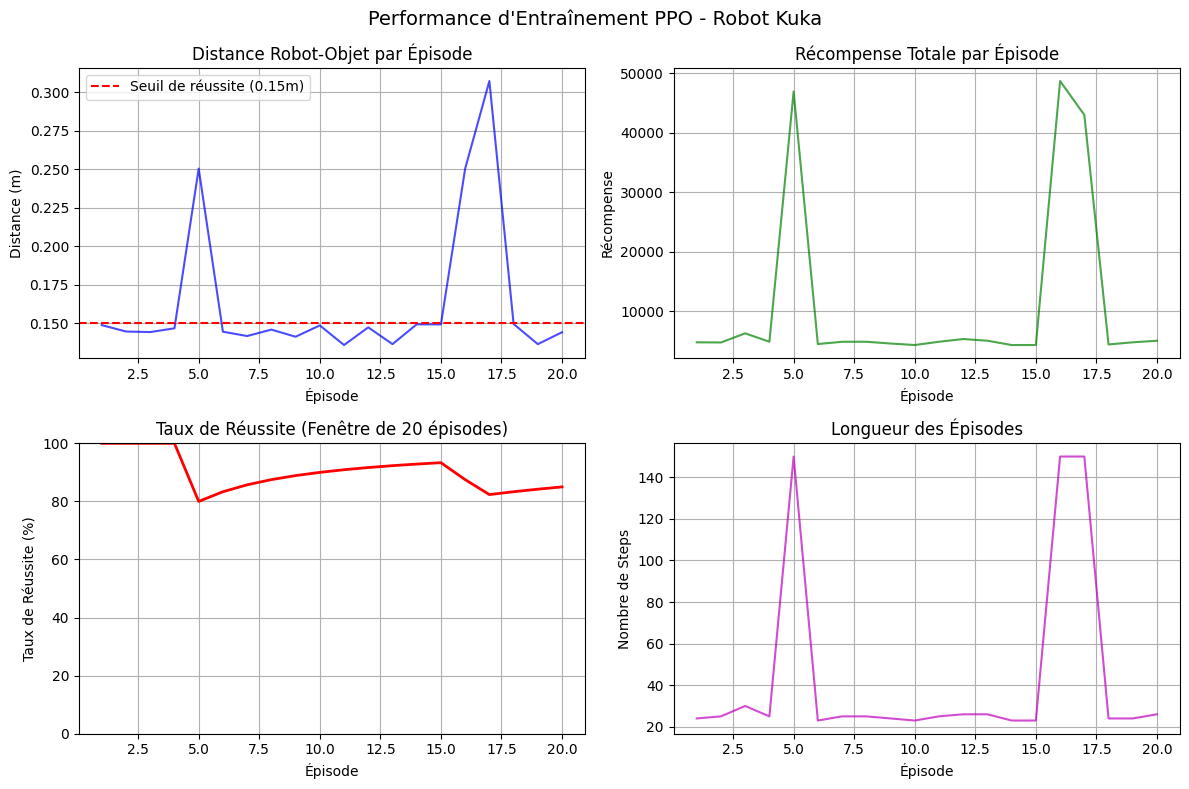

Graphique de performance sauvegardé: test_performance_graphics.png

RAPPORT FINAL DE TEST - PERFORMANCES DETAILLEES
PARAMETRES DU TEST:
   Modele teste: models/ppo_kuka_7dof_final50krec
   Episodes: 20
   Seuil de reussite: 0.15m
   Affichage visuel: Active

RESULTATS GLOBAUX:
   Taux de reussite: 85.0% (17/20)

ANALYSE DES DISTANCES:
   Distance moyenne: 0.163m
   Meilleure distance: 0.136m
   Pire distance: 0.307m
   Ecart-type: 0.046m
   Consistance: 71.8%

ANALYSE DES RECOMPENSES:
   Recompense moyenne: 11017.6
   Meilleure recompense: 48674.1
   Pire recompense: 4313.7

ANALYSE DE L'EFFICACITE:
   Longueur moyenne: 43.5 steps
   Episode plus court: 23 steps
   Episode plus long: 150 steps

EVALUATION DE LA PERFORMANCE:
   Evaluation: EXCELLENT (85.0%)
   Commentaire: Tres bonnes performances! Qualite professionnelle.

RECOMMANDATIONS:
   - Performance excellente! Deploiement possible.
   - Tester avec un seuil plus strict pour validation.
   - Considerer des tests en conditions re

<Figure size 640x480 with 0 Axes>

In [12]:
# Test standard avec votre modèle (PLUS SIMPLE)
results = run_standard_test()

In [ ]:
from stable_baselines3 import PPO
import numpy as np
import time
import os
import json
from datetime import datetime
from collections import deque
import matplotlib.pyplot as plt
import glob

def save_results_to_json(results, filename=None):
    if results is None:
        print("ERREUR: Aucun resultat a sauvegarder")
        return None
    
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_name = results.get('model_path', 'model').replace('models/', '').replace('/', '_')
        filename = f"test_results_{model_name}_{timestamp}.json"
    
    try:
        json_data = {
            "test_metadata": {
                "timestamp": datetime.now().isoformat(),
                "model_path": results.get('model_path', 'Unknown'),
                "test_parameters": results.get('test_parameters', {}),
                "total_episodes": results.get('total_episodes', 0)
            },
            
            "global_statistics": {
                "success_rate_percent": float(results.get('success_rate', 0)),
                "total_successes": int(results.get('successes', 0)),
                "total_episodes": int(results.get('total_episodes', 0)),
                
                "distance_metrics": {
                    "average_distance": float(results.get('avg_distance', 0)),
                    "best_distance": float(results.get('min_distance', 0)),
                    "worst_distance": float(results.get('max_distance', 0)),
                    "distance_std_deviation": float(results.get('std_distance', 0)),
                    "threshold_used": float(results.get('test_parameters', {}).get('threshold', 0.15))
                },
                
                "reward_metrics": {
                    "average_reward": float(results.get('avg_reward', 0)),
                    "best_reward": float(results.get('max_reward', 0)),
                    "worst_reward": float(results.get('min_reward', 0))
                },
                
                "efficiency_metrics": {
                    "average_episode_length": float(results.get('avg_length', 0)),
                    "shortest_episode": int(results.get('min_length', 0)),
                    "longest_episode": int(results.get('max_length', 0)),
                    "consistency_score_percent": float(results.get('consistency_score', 0))
                }
            },
            
            "detailed_episodes": []
        }
        
        if 'success_details' in results:
            for episode_data in results['success_details']:
                episode_json = {
                    "episode_number": int(episode_data.get('episode', 0)),
                    "success": bool(episode_data.get('success', False)),
                    "final_distance_meters": float(episode_data.get('distance', 0)),
                    "total_reward": float(episode_data.get('reward', 0)),
                    "episode_length_steps": int(episode_data.get('steps', 0)),
                    
                    "performance_grade": _evaluate_episode_performance(
                        episode_data.get('distance', 0),
                        episode_data.get('success', False),
                        results.get('test_parameters', {}).get('threshold', 0.15)
                    ),
                    
                    "efficiency_score": _calculate_efficiency_score(
                        episode_data.get('steps', 0),
                        episode_data.get('success', False),
                        results.get('max_length', 150)
                    )
                }
                json_data["detailed_episodes"].append(episode_json)
        
        json_data["analysis"] = {
            "success_distribution": _analyze_success_distribution(results),
            "performance_trends": _analyze_performance_trends(results),
            "recommendations": _generate_recommendations(results)
        }
        
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(json_data, f, indent=2, ensure_ascii=False)
        
        print(f"Resultats sauvegardes dans: {filename}")
        print(f"Taille du fichier: {len(json.dumps(json_data, indent=2))} caracteres")
        print(f"Episodes enregistres: {len(json_data['detailed_episodes'])}")
        
        return filename
        
    except Exception as e:
        print(f"ERREUR lors de la sauvegarde JSON: {e}")
        return None

def _evaluate_episode_performance(distance, success, threshold):
    if success:
        if distance < threshold * 0.5:
            return "EXCELLENT"
        elif distance < threshold * 0.75:
            return "TRES_BIEN"
        else:
            return "BIEN"
    else:
        if distance < threshold * 1.5:
            return "PROCHE"
        elif distance < threshold * 2.0:
            return "MOYEN"
        else:
            return "FAIBLE"

def _calculate_efficiency_score(steps, success, max_steps):
    if success:
        efficiency = ((max_steps - steps) / max_steps) * 100
        return max(0, min(100, efficiency))
    else:
        return max(0, 25 - (steps / max_steps) * 25)

def _analyze_success_distribution(results):
    if 'success_details' not in results:
        return {}
    
    episodes = results['success_details']
    total = len(episodes)
    
    if total == 0:
        return {}
    
    successes = [ep for ep in episodes if ep.get('success', False)]
    failures = [ep for ep in episodes if not ep.get('success', False)]
    
    analysis = {
        "total_episodes": total,
        "successes": len(successes),
        "failures": len(failures),
        "success_rate": (len(successes) / total) * 100
    }
    
    if successes:
        success_distances = [ep['distance'] for ep in successes]
        analysis["success_metrics"] = {
            "average_success_distance": float(np.mean(success_distances)),
            "best_success_distance": float(min(success_distances)),
            "worst_success_distance": float(max(success_distances))
        }
    
    if failures:
        failure_distances = [ep['distance'] for ep in failures]
        analysis["failure_metrics"] = {
            "average_failure_distance": float(np.mean(failure_distances)),
            "closest_failure_distance": float(min(failure_distances)),
            "worst_failure_distance": float(max(failure_distances))
        }
    
    return analysis

def _analyze_performance_trends(results):
    if 'success_details' not in results:
        return {}
    
    episodes = results['success_details']
    if len(episodes) < 5:
        return {"note": "Pas assez d'episodes pour analyser les tendances"}
    
    mid_point = len(episodes) // 2
    first_half = episodes[:mid_point]
    second_half = episodes[mid_point:]
    
    first_success_rate = (sum(1 for ep in first_half if ep.get('success', False)) / len(first_half)) * 100
    second_success_rate = (sum(1 for ep in second_half if ep.get('success', False)) / len(second_half)) * 100
    
    first_avg_distance = np.mean([ep['distance'] for ep in first_half])
    second_avg_distance = np.mean([ep['distance'] for ep in second_half])
    
    return {
        "first_half_success_rate": float(first_success_rate),
        "second_half_success_rate": float(second_success_rate),
        "success_rate_improvement": float(second_success_rate - first_success_rate),
        
        "first_half_avg_distance": float(first_avg_distance),
        "second_half_avg_distance": float(second_avg_distance),
        "distance_improvement": float(first_avg_distance - second_avg_distance),
        
        "trend_interpretation": "AMELIORATION" if second_success_rate > first_success_rate else 
                              "STABLE" if abs(second_success_rate - first_success_rate) < 5 else "DEGRADATION"
    }

def _generate_recommendations(results):
    success_rate = results.get('success_rate', 0)
    avg_distance = results.get('avg_distance', 1.0)
    consistency = results.get('consistency_score', 0)
    
    recommendations = []
    
    if success_rate >= 90:
        recommendations.append("Performance exceptionnelle! Modele pret pour production.")
    elif success_rate >= 75:
        recommendations.append("Bonnes performances. Tester avec seuil plus strict.")
    elif success_rate >= 50:
        recommendations.append("Performance correcte. Entrainement supplementaire recommande.")
    else:
        recommendations.append("Performance insuffisante. Revoir configuration d'entrainement.")
    
    if avg_distance > 0.5:
        recommendations.append("Distance moyenne elevee. Optimiser fonction de recompense.")
    
    if consistency < 70:
        recommendations.append("Consistance faible. Stabiliser l'entrainement.")
    
    if len(recommendations) == 0:
        recommendations.append("Aucune recommandation specifique.")
    
    return recommendations

def load_results_from_json(filename):
    try:
        with open(filename, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        print(f"Resultats charges depuis: {filename}")
        print(f"Test effectue le: {data['test_metadata']['timestamp']}")
        print(f"Modele: {data['test_metadata']['model_path']}")
        print(f"Episodes: {data['test_metadata']['total_episodes']}")
        print(f"Taux de reussite: {data['global_statistics']['success_rate_percent']:.1f}%")
        
        return data
        
    except FileNotFoundError:
        print(f"ERREUR: Fichier non trouve: {filename}")
        return None
    except json.JSONDecodeError:
        print(f"ERREUR: Fichier JSON invalide: {filename}")
        return None
    except Exception as e:
        print(f"ERREUR lors du chargement: {e}")
        return None

def display_json_summary(json_data):
    if json_data is None:
        print("Aucune donnee a afficher")
        return
    
    print("\n" + "="*60)
    print("RESUME DES RESULTATS JSON")
    print("="*60)
    
    meta = json_data.get('test_metadata', {})
    print(f"Date du test: {meta.get('timestamp', 'Inconnue')}")
    print(f"Modele: {meta.get('model_path', 'Inconnu')}")
    
    stats = json_data.get('global_statistics', {})
    print(f"\nPerformance globale:")
    print(f"   Taux de reussite: {stats.get('success_rate_percent', 0):.1f}%")
    print(f"   Episodes: {stats.get('total_episodes', 0)}")
    
    dist = stats.get('distance_metrics', {})
    print(f"\nDistances:")
    print(f"   Moyenne: {dist.get('average_distance', 0):.3f}m")
    print(f"   Meilleure: {dist.get('best_distance', 0):.3f}m")
    
    episodes = json_data.get('detailed_episodes', [])
    if episodes:
        successes = [ep for ep in episodes if ep.get('success', False)]
        print(f"\nEpisodes reussis: {len(successes)}/{len(episodes)}")
        
        if successes:
            best_episode = min(successes, key=lambda x: x.get('final_distance_meters', 1.0))
            print(f"Meilleur episode: #{best_episode.get('episode_number', 0)} "
                  f"(distance: {best_episode.get('final_distance_meters', 0):.3f}m)")
    
    recommendations = json_data.get('analysis', {}).get('recommendations', [])
    if recommendations:
        print(f"\nRecommandations:")
        for i, rec in enumerate(recommendations, 1):
            print(f"   {i}. {rec}")
    
    print("="*60)

def list_json_files():
    json_files = glob.glob("test_results_*.json")
    
    if not json_files:
        print("Aucun fichier de resultats JSON trouve.")
        print("Les fichiers sont generes automatiquement lors des tests.")
        return []
    
    print("FICHIERS DE RESULTATS JSON DISPONIBLES:")
    print("-" * 50)
    
    for i, filename in enumerate(sorted(json_files), 1):
        try:
            with open(filename, 'r') as f:
                data = json.load(f)
            
            timestamp = data.get('test_metadata', {}).get('timestamp', 'Inconnu')
            model = data.get('test_metadata', {}).get('model_path', 'Inconnu')
            success_rate = data.get('global_statistics', {}).get('success_rate_percent', 0)
            episodes = data.get('test_metadata', {}).get('total_episodes', 0)
            
            print(f"{i}. {filename}")
            print(f"   Date: {timestamp[:19] if len(timestamp) > 19 else timestamp}")
            print(f"   Modele: {model}")
            print(f"   Reussite: {success_rate:.1f}% ({episodes} episodes)")
            print()
            
        except:
            print(f"{i}. {filename} (erreur lecture)")
            print()
    
    return sorted(json_files)

def test_model_with_graphics(model_path="models/ppo_kuka_7dof_final50krec", n_episodes=20, threshold=0.15, force_visual=True):
    print("DEMARRAGE DU TEST AVEC AFFICHAGE GRAPHIQUE")
    print("=" * 70)
    print(f"Modele a tester: {model_path}")
    print(f"Nombre d'episodes: {n_episodes}")
    print(f"Seuil de reussite: {threshold}m")
    print(f"Affichage: Simulation visuelle + Graphiques en temps reel")
    print("=" * 70)
    
    try:
        print("0. Nettoyage des connexions PyBullet...")
        try:
            import pybullet as p
            p.disconnect()
            print("   Connexions precedentes fermees")
        except:
            print("   Aucune connexion precedente detectee")
        
        print("1. Verification et chargement du modele...")
        if not os.path.exists(f"{model_path}.zip"):
            print(f"ERREUR: Fichier modele non trouve: {model_path}.zip")
            print("SOLUTIONS POSSIBLES:")
            print(f"   - Verifier que l'entrainement s'est bien termine")
            print(f"   - Verifier le dossier models/")
            print(f"   - Utiliser le bon nom de fichier")
            return None
        
        model = PPO.load(model_path)
        print(f"   Modele charge avec succes depuis: {model_path}.zip")
        
        print("2. Creation de l'environnement...")
        visual_mode = True
        try:
            env = Kuka7DOFEnv(renders=True)
            print(f"   Environnement cree avec simulation visuelle ACTIVE")
        except Exception as e:
            if force_visual:
                print(f"   ATTENTION: Erreur GUI PyBullet - {e}")
                print("   Tentative en mode DIRECT (sans affichage 3D)...")
                try:
                    env = Kuka7DOFEnv(renders=False)
                    visual_mode = False
                    print(f"   Environnement cree en mode DIRECT (pas d'affichage 3D)")
                except Exception as e2:
                    print(f"   ECHEC creation environnement: {e2}")
                    return None
            else:
                raise e
        
        env.success_distance_threshold = threshold
        print(f"   Seuil de reussite configure: {env.success_distance_threshold}m")
        
        if not visual_mode:
            print("   NOTE: Seuls les graphiques de performance seront affiches")
            print("         (pas de simulation 3D du robot)")
        
        print("3. Initialisation du tracker de performance graphique...")
        performance_tracker = PerformanceTracker(window_size=min(20, n_episodes))
        print(f"   Tracker initialise pour {n_episodes} episodes")
        
        results = {
            'episodes': [],
            'successes': 0,
            'distances': [],
            'rewards': [],
            'episode_lengths': [],
            'success_details': [],
            'model_path': model_path,
            'test_parameters': {
                'n_episodes': n_episodes,
                'threshold': threshold,
                'visualization': visual_mode
            }
        }
        
        print(f"\n4. EXECUTION DES {n_episodes} EPISODES DE TEST")
        print("-" * 70)
        print("Format: Episode XX: STATUS | Distance: X.XXXm | Reward: XXXX.X | Steps: XXX")
        print("-" * 70)
        
        for episode in range(n_episodes):
            obs = env.reset()
            episode_reward = 0
            episode_steps = 0
            
            print(f"Episode {episode+1:2d} en cours...", end=" ")
            
            for step in range(env.max_steps):
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, done, info = env.step(action)
                
                episode_reward += reward
                episode_steps += 1
                
                if done:
                    break
            
            ee_pos = obs[17:20]
            obj_pos = obs[14:17]
            final_distance = np.linalg.norm(np.array(ee_pos) - np.array(obj_pos))
            
            success = final_distance < threshold
            if success:
                results['successes'] += 1
            
            performance_tracker.update(
                episode_num=episode + 1,
                final_distance=final_distance,
                total_reward=episode_reward,
                episode_length=episode_steps,
                success=success
            )
            
            results['episodes'].append(episode + 1)
            results['distances'].append(final_distance)
            results['rewards'].append(episode_reward)
            results['episode_lengths'].append(episode_steps)
            results['success_details'].append({
                'episode': episode + 1,
                'success': success,
                'distance': final_distance,
                'reward': episode_reward,
                'steps': episode_steps
            })
            
            status = "SUCCES" if success else "ECHEC"
            print(f"Episode {episode+1:2d}: {status:6s} | "
                  f"Distance: {final_distance:.3f}m | "
                  f"Reward: {episode_reward:7.1f} | "
                  f"Steps: {episode_steps:3d}")
            
            if episode < n_episodes - 1:
                time.sleep(1.0)
        
        print("6. Fermeture de l'environnement...")
        try:
            env.close()
            print("   Environnement ferme correctement")
        except:
            print("   Fermeture automatique")
        print("-" * 70)
        
        print("5. Calcul des statistiques finales...")
        
        success_rate = (results['successes'] / n_episodes) * 100
        avg_distance = np.mean(results['distances'])
        min_distance = min(results['distances'])
        max_distance = max(results['distances'])
        std_distance = np.std(results['distances'])
        
        avg_reward = np.mean(results['rewards'])
        max_reward = max(results['rewards'])
        min_reward = min(results['rewards'])
        
        avg_length = np.mean(results['episode_lengths'])
        min_length = min(results['episode_lengths'])
        max_length = max(results['episode_lengths'])
        
        consistency_score = max(0, 100 - (std_distance / avg_distance * 100)) if avg_distance > 0 else 0
        
        results.update({
            'success_rate': success_rate,
            'avg_distance': avg_distance,
            'min_distance': min_distance,
            'max_distance': max_distance,
            'std_distance': std_distance,
            'avg_reward': avg_reward,
            'max_reward': max_reward,
            'min_reward': min_reward,
            'avg_length': avg_length,
            'min_length': min_length,
            'max_length': max_length,
            'consistency_score': consistency_score,
            'total_episodes': n_episodes
        })
        
        print("6. Sauvegarde des resultats...")
        performance_tracker.save_final_plot(filename="test_performance_graphics.png")
        
        json_filename = save_results_to_json(results)
        print(f"   - Graphique sauvegarde: test_performance_graphics.png")
        if json_filename:
            print(f"   - Donnees JSON sauvegardees: {json_filename}")
        else:
            print(f"   - ERREUR: Echec sauvegarde JSON")
        
        print("\n" + "=" * 70)
        print("RAPPORT FINAL DE TEST - PERFORMANCES DETAILLEES")
        print("=" * 70)
        
        print("PARAMETRES DU TEST:")
        print(f"   Modele teste: {model_path}")
        print(f"   Episodes: {n_episodes}")
        print(f"   Seuil de reussite: {threshold}m")
        print(f"   Affichage visuel: {'Active' if visual_mode else 'Desactive'}")
        
        print(f"\nRESULTATS GLOBAUX:")
        print(f"   Taux de reussite: {success_rate:.1f}% ({results['successes']}/{n_episodes})")
        
        print(f"\nANALYSE DES DISTANCES:")
        print(f"   Distance moyenne: {avg_distance:.3f}m")
        print(f"   Meilleure distance: {min_distance:.3f}m")
        print(f"   Pire distance: {max_distance:.3f}m")
        print(f"   Ecart-type: {std_distance:.3f}m")
        print(f"   Consistance: {consistency_score:.1f}%")
        
        print(f"\nANALYSE DES RECOMPENSES:")
        print(f"   Recompense moyenne: {avg_reward:.1f}")
        print(f"   Meilleure recompense: {max_reward:.1f}")
        print(f"   Pire recompense: {min_reward:.1f}")
        
        print(f"\nANALYSE DE L'EFFICACITE:")
        print(f"   Longueur moyenne: {avg_length:.1f} steps")
        print(f"   Episode plus court: {min_length} steps")
        print(f"   Episode plus long: {max_length} steps")
        
        print(f"\nEVALUATION DE LA PERFORMANCE:")
        if success_rate >= 95:
            evaluation = "EXCEPTIONNEL"
            commentary = "Performance parfaite! Modele pret pour production."
        elif success_rate >= 85:
            evaluation = "EXCELLENT"
            commentary = "Tres bonnes performances! Qualite professionnelle."
        elif success_rate >= 75:
            evaluation = "TRES BIEN"
            commentary = "Bonnes performances globales!"
        elif success_rate >= 65:
            evaluation = "BIEN"
            commentary = "Performance correcte avec marge d'amelioration."
        elif success_rate >= 50:
            evaluation = "MOYEN"
            commentary = "Performance acceptable mais entrainement supplementaire recommande."
        elif success_rate >= 30:
            evaluation = "FAIBLE"
            commentary = "Performance insuffisante. Revision necessaire."
        else:
            evaluation = "TRES FAIBLE"
            commentary = "Performance inadequate. Probleme majeur detecte."
        
        print(f"   Evaluation: {evaluation} ({success_rate:.1f}%)")
        print(f"   Commentaire: {commentary}")
        
        print(f"\nRECOMMANDATIONS:")
        if success_rate >= 85:
            print("   - Performance excellente! Deploiement possible.")
            print("   - Tester avec un seuil plus strict pour validation.")
            print("   - Considerer des tests en conditions reelles.")
        elif success_rate >= 65:
            print("   - Performance correcte mais perfectible.")
            print("   - Entrainement complementaire recommande.")
            print("   - Analyser les echecs pour optimisation.")
        else:
            print("   - Performance insuffisante pour deploiement.")
            print("   - Revoir les hyperparametres d'entrainement.")
            print("   - Augmenter significativement les timesteps.")
            print("   - Verifier la fonction de recompense.")
        
        print(f"\nFICHIERS GENERES:")
        print(f"   - Graphique de performance: test_performance_graphics.png")
        print(f"   - Donnees detaillees JSON: {json_filename if json_filename else 'ERREUR'}")
        print(f"   - Donnees de test: Retournees dans l'objet results")
        print(f"   - Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        
        print("=" * 70)
        print("TEST TERMINE AVEC SUCCES!")
        print("=" * 70)
        
        return results
        
    except FileNotFoundError as e:
        print(f"ERREUR: Fichier non trouve - {e}")
        print("SOLUTIONS:")
        print("   1. Verifier que l'entrainement s'est termine correctement")
        print("   2. Verifier le chemin du modele")
        print("   3. S'assurer que le fichier .zip existe")
        return None
        
    except Exception as e:
        print(f"ERREUR inattendue pendant le test: {e}")
        print("SOLUTIONS POSSIBLES:")
        print("   1. Si erreur PyBullet GUI: utiliser run_test_direct_mode()")
        print("   2. Redemarrer le noyau Python")
        print("   3. Verifier que toutes les dependencies sont installees")
        
        try:
            if 'env' in locals():
                env.close()
            import pybullet as p
            p.disconnect()
        except:
            pass
        return None

def run_standard_test(model_path="models/ppo_kuka_7dof_final50krec"):
    print("LANCEMENT DU TEST STANDARD")
    print("Configuration: 20 episodes, affichage complet, seuil 0.15m")
    print("-" * 50)
    
    results = test_model_with_graphics(
        model_path=model_path,
        n_episodes=20,
        threshold=0.15,
        force_visual=True
    )
    
    if results:
        print(f"\nTEST TERMINE! Taux de reussite: {results['success_rate']:.1f}%")
        return results
    else:
        print("\nECHEC DU TEST! Voir les messages d'erreur ci-dessus.")
        return None

def run_test_direct_mode(model_path="models/ppo_kuka_7dof_final50krec"):
    print("LANCEMENT DU TEST EN MODE DIRECT")
    print("Configuration: 20 episodes, graphiques uniquement, pas d'affichage 3D")
    print("-" * 50)
    
    results = test_model_with_graphics(
        model_path=model_path,
        n_episodes=20,
        threshold=0.15,
        force_visual=False
    )
    
    if results:
        print(f"\nTEST TERMINE! Taux de reussite: {results['success_rate']:.1f}%")
        return results
    else:
        print("\nECHEC DU TEST!")
        return None

if __name__ == "__main__":
    print("EXEMPLES D'UTILISATION:")
    print("-" * 50)
    print("1. Test standard avec votre modele (RECOMMANDE):")
    print('   results = run_standard_test()')
    print('   # Genere automatiquement: test_performance_graphics.png et test_results_*.json')
    print("")
    print("2. Test en mode direct (si probleme GUI):")
    print('   results = run_test_direct_mode()')
    print("")
    print("3. Gestion des fichiers JSON:")
    print('   list_json_files()  # Liste tous les tests precedents')
    print('   data = load_results_from_json("test_results_xxxxx.json")')
    print('   display_json_summary(data)  # Affiche un resume')
    print("")
    print("4. Sauvegarde manuelle en JSON:")
    print('   save_results_to_json(results, "mon_test_special.json")')
    print("")
    print("5. Test personnalise:")
    print('   results = test_model_with_graphics(n_episodes=30, threshold=0.10)')
    print("")
    print("UTILISATION IMMEDIATE (modele configure automatiquement):")
    print('results = run_standard_test()')
    print("")
    print("GESTION DES RESULTATS:")
    print('list_json_files()  # Voir tous les tests')
    print("")
    print("Si erreur PyBullet GUI, essayez:")
    print('results = run_test_direct_mode()')

EXEMPLES D'UTILISATION:
--------------------------------------------------
1. Test standard avec votre modele (RECOMMANDE):
   results = run_standard_test()
   # Genere automatiquement: test_performance_graphics.png et test_results_*.json

2. Test en mode direct (si probleme GUI):
   results = run_test_direct_mode()

3. Gestion des fichiers JSON:
   list_json_files()  # Liste tous les tests precedents
   data = load_results_from_json("test_results_xxxxx.json")
   display_json_summary(data)  # Affiche un resume

4. Sauvegarde manuelle en JSON:
   save_results_to_json(results, "mon_test_special.json")

5. Test personnalise:
   results = test_model_with_graphics(n_episodes=30, threshold=0.10)

UTILISATION IMMEDIATE (modele configure automatiquement):
results = run_standard_test()

GESTION DES RESULTATS:
list_json_files()  # Voir tous les tests

Si erreur PyBullet GUI, essayez:
results = run_test_direct_mode()
